# Homework (10 points)

In this homework we train Sound Event Detection model.

Dataset: https://disk.yandex.ru/d/NRpDIp4jg2ODqg

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

# implementation of Dataset for given data|
import dataset

from IPython.display import clear_output

%matplotlib inline

In [3]:
import requests
from urllib.parse import urlencode
from io import BytesIO
from tarfile import TarFile
import tarfile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/NRpDIp4jg2ODqg'
dst_path = '/home/jupyter/mnt/datasets/sound_event_detection/dataset/' # if we make the Datasphere datasets work
dst_path = './dataset/'

# final_url = base_url + urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']

# if you aren't in the Datasphere
# !wget -O data.tar.gz  "{download_url}"
# !tar -xf data.tar.gz 

# otherwise
# response = requests.get(download_url)
# io_bytes = BytesIO(response.content)
# tar = tarfile.open(fileobj=io_bytes, mode='r:gz')
# tar.extractall(path=dst_path)


In [4]:
DEVICE = 'cuda' # also you can use "cuda" for gpu and "mps" for apple silicon
DATADIR = dst_path + 'data'
LOADER_WORKERS = 4

In [5]:
# FBANK 80 by default, but you can choose something else
FEATS = 80
transform_train = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(n_mels=FEATS),
    torchaudio.transforms.AmplitudeToDB(),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
)
transform_test = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(n_mels=FEATS),
    torchaudio.transforms.AmplitudeToDB()
)
trainset = dataset.Dataset('train', DATADIR, transform_train)
testset = dataset.Dataset('eval', DATADIR, transform_test)
N_CLASSES = trainset.classes()

In [6]:
N_CLASSES

30

In [7]:
trainset[0][0].shape

torch.Size([80, 801])

### Eval part (1 point)

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [8]:
# Get list of pairs (target_class, predicted_class)
from collections import defaultdict
def balanced_accuracy(items: list[tuple[int, int]]) -> float:
    result = 0
    
    correct_pred_by_class = defaultdict(int)
    class_el_counter = defaultdict(int)
    
    for target, pred in items:
        correct_pred_by_class[target] += (target == pred)
        class_el_counter[target] += 1
        
    for c in class_el_counter:
        result += correct_pred_by_class[c] / class_el_counter[c]
    result /= len(class_el_counter)

    return result
        

In [9]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)]), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)]), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)]), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)]), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)]), 0.66666666666666)

### Train part (9 points)

Train some model with test accuracy > 0.5

You can train any model you want. The only limitation is that it must be trained from scratch on the data provided in the task.

For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

If you use a model like Conformer, Resnet*, Mobilenet* you should achieve accuracy of at least 0.53 (?). It is advised to draw inspiration from the big models and build your own small model from scratch.

Hints:
- No need to train large models for this task. 10 million parameters is more than you need.
- The score can be achieved by models less than 100K params
- Take the feature dimension into account
- Monitor overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Score of 0.35 is easily achievable by CNN 1d
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Pay attention to the time dimension at the end of the network. How big is the receptive field of the network?
- Try different features (mel-spec, log-mel-spec, mfcc)
- You may need more than 10 epochs. One would would consider 20-30 epochs as a reasonable estimate
- You may need to use smaller batches)

P.S. Points can be subtracted for unclear training charts. Keep all the experiments that you've run in the notebook.

PP.S. It is sufficient for your model to beat the threshold once. We imagine a) there is a hidden best checkpoint save option and b) that the distribution of the test used to monitor the training is identical to the distribution of all possible tests)

PP.S. A partial score will be awarded for a test accuracy < 0.5. Score of 0.35 is easily achievable by CNN 1d

PPP.S. Add log to Melspectrogram in torchaudio.transform

In [10]:
def get_num_params(model):
    result = 0
    for param in model.parameters():
        result += param.numel()
    return result


def stage(
    model: nn.Module,
    data: dataset.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 128,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=dataset.collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        pred = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    opt,
    batch_size: int = 128,
    epochs: int = 10,
):
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = stage(model, trainset, opt, batch_size=batch_size)
        test_loss, test_acc = stage(model, testset, opt, batch_size=batch_size, train=False)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), test_losses, label='test')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(1, epoch + 2), test_accs, label='test')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {test_loss}. Test accuracy {test_acc}')

In [11]:
class DepthwiseSeparable(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padidng=0):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            groups=in_channels
        )
        self.pointwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
        )
    
    def forward(self, X):
        return self.pointwise(self.depthwise(X))

class ConvBlock(nn.Module):
    def __init__(self, conv_layer, out_channels):
        super().__init__()
        self.conv_layer = conv_layer
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        return self.relu(self.batchnorm(self.conv_layer(X)))

class Model(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
        super().__init__()
        self.out_dim = out_dim
        self.in_dim = in_dim
        self.sequential = nn.Sequential(
            ConvBlock(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding="same"), out_channels=8),
            # nn.MaxPool2d(kernel_size=2),
            
            ConvBlock(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1), out_channels=16),
            nn.Dropout(0.1),

            ConvBlock(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same"), out_channels=32),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.1),

            ConvBlock(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2), out_channels=64),
            nn.Dropout(0.2),
            
            ConvBlock(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2), out_channels=128),
            # nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
            
            ConvBlock(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1), out_channels=256),

            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, self.out_dim)
        )
        
       
    def forward(self, X):
        # input: [batch_size, IN_FEATURES, TIME]
        # output: [batch_size, N_CLASSES]
        X = X.unsqueeze(1)
        return self.sequential(X)

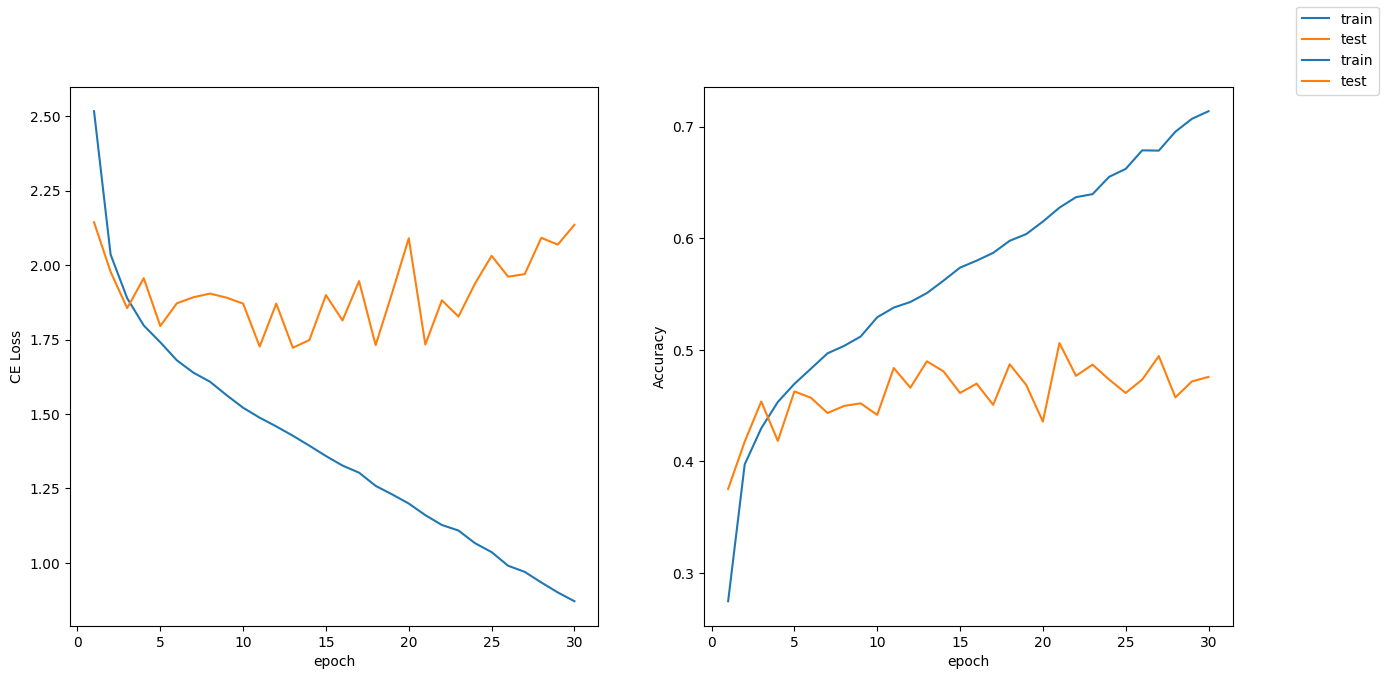

Epoch 30.
Train loss 0.8715240946630153. Train accuracy 0.713703517718952.
Test loss 2.135382130742073. Test accuracy 0.4756666666666666


In [13]:
#change transforms
model = Model().to(DEVICE)
print("Number of parameters is ", get_num_params(model))
opt = optim.Adam(model.parameters())
train(model, opt, epochs=30)

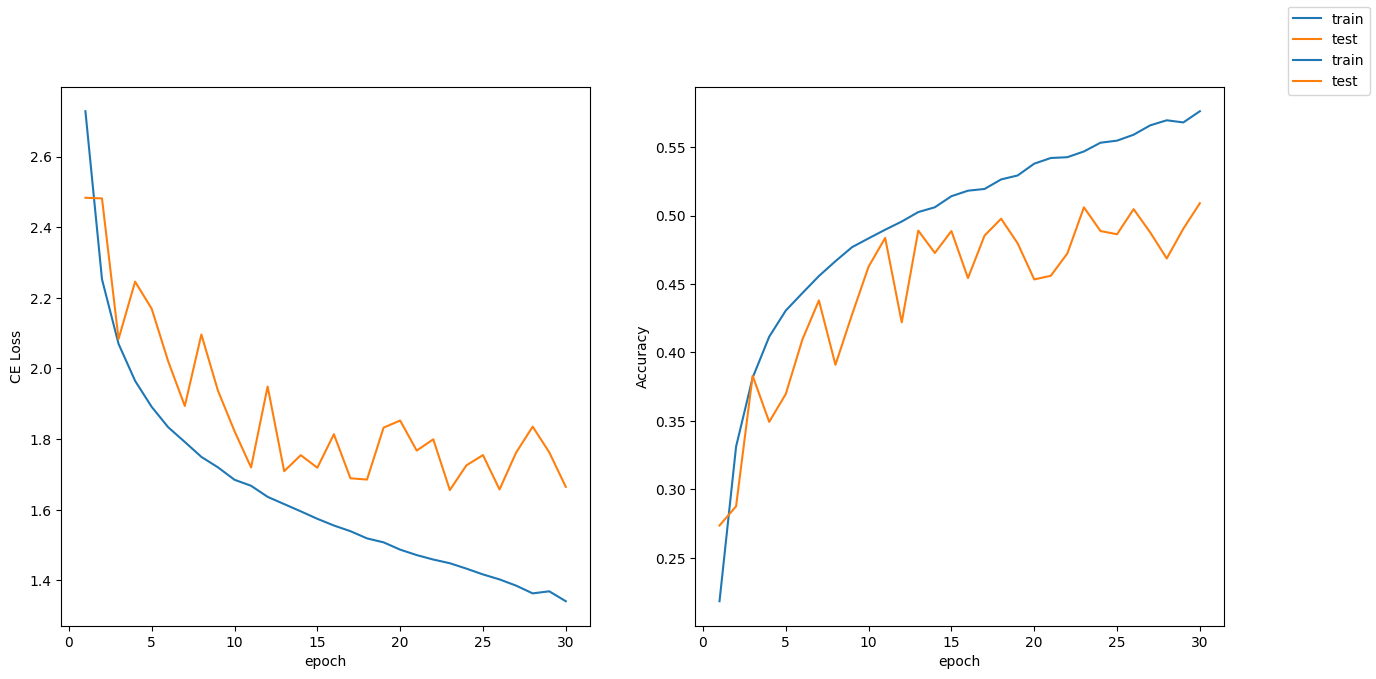

Epoch 30.
Train loss 1.3412105670789394. Train accuracy 0.5761606068045846.
Test loss 1.6649020711580913. Test accuracy 0.509


In [12]:
#more augmentation, less lr and mode Dropouts
model = Model().to(DEVICE)
print("Number of parameters is ", get_num_params(model))
opt = optim.Adam(model.parameters(), lr=0.0007)
train(model, opt, epochs=30)

In [13]:
class DepthwiseSeparable(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padidng=0):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            groups=in_channels
        )
        self.pointwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
        )
    
    def forward(self, X):
        return self.pointwise(self.depthwise(X))

class ConvBlock(nn.Module):
    def __init__(self, conv_layer, out_channels):
        super().__init__()
        self.conv_layer = conv_layer
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        return self.relu(self.batchnorm(self.conv_layer(X)))

class Model(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
        super().__init__()
        self.out_dim = out_dim
        self.in_dim = in_dim
        self.sequential = nn.Sequential(
            ConvBlock(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding="same"), out_channels=8),
            # nn.MaxPool2d(kernel_size=2),
            
            ConvBlock(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1), out_channels=16),
            nn.Dropout(0.1),
            
            ConvBlock(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1), out_channels=16),
            nn.Dropout(0.1),

            ConvBlock(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same"), out_channels=32),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.1),

            ConvBlock(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2), out_channels=64),
            nn.Dropout(0.2),
            
            ConvBlock(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2), out_channels=128),
            # nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
            
            ConvBlock(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1), out_channels=256),

            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, self.out_dim)
        )
        
       
    def forward(self, X):
        # input: [batch_size, IN_FEATURES, TIME]
        # output: [batch_size, N_CLASSES]
        X = X.unsqueeze(1)
        return self.sequential(X)

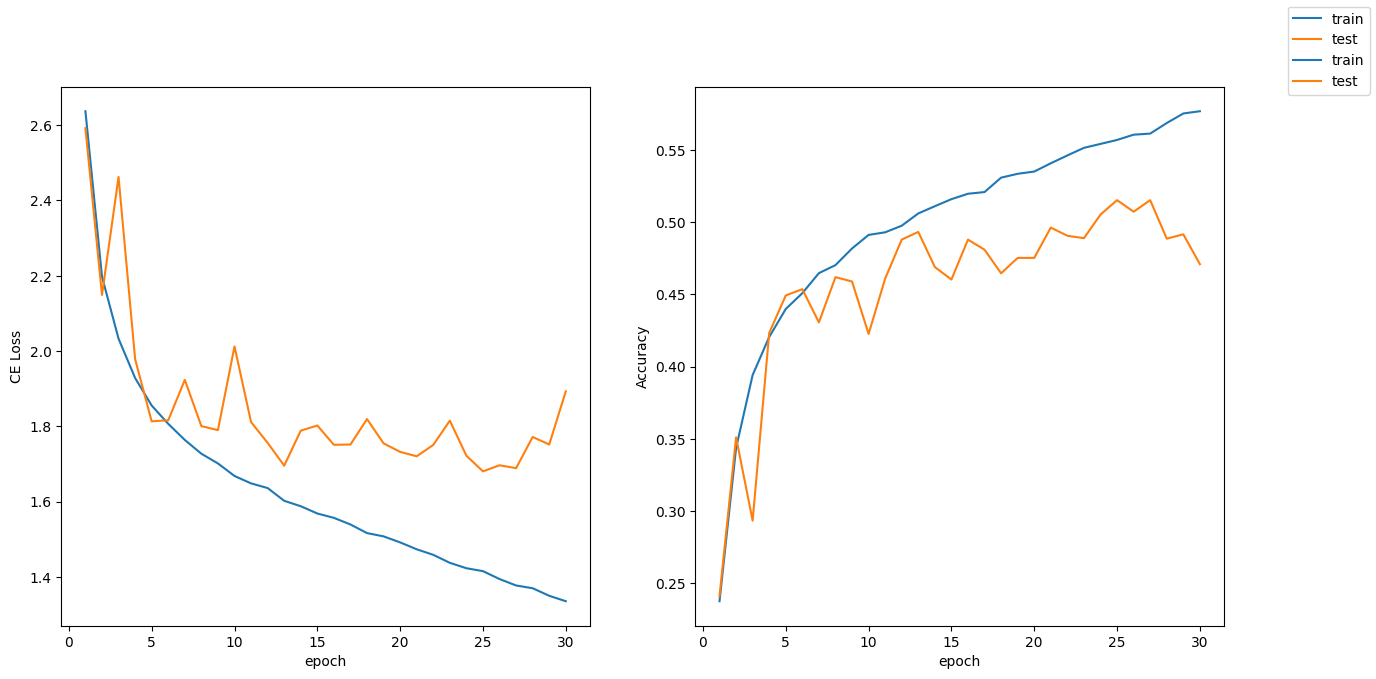

Epoch 30.
Train loss 1.3354277645669332. Train accuracy 0.5769403462312409.
Test loss 1.8928344895442326. Test accuracy 0.471


In [14]:
#more CNNs
model = Model().to(DEVICE)
print("Number of parameters is ", get_num_params(model))
opt = optim.Adam(model.parameters(), lr=0.0008)
train(model, opt, epochs=30)

#### Okay, the second exp is the best with acc = 0.509, duplicate it final here >

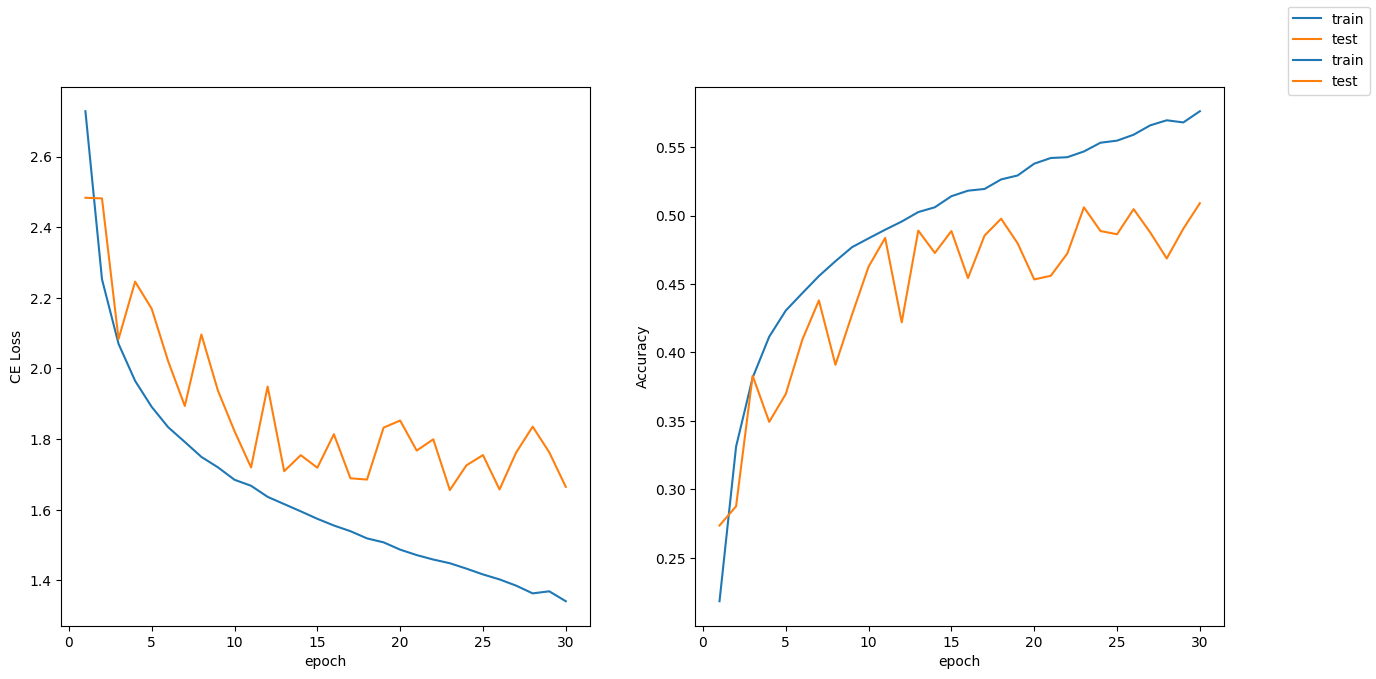

Epoch 30.
Train loss 1.3412105670789394. Train accuracy 0.5761606068045846.
Test loss 1.6649020711580913. Test accuracy 0.509


In [12]:
#more augmentation, less lr and mode Dropouts
model = Model().to(DEVICE)
print("Number of parameters is ", get_num_params(model))
opt = optim.Adam(model.parameters(), lr=0.0007)
train(model, opt, epochs=30)